In [2]:
import torch
import torch.nn as nn
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import mlflow.pytorch

In [10]:
data_dir = '../data/processed/'
models_dir = 'models/'
model_path = os.path.join(models_dir, 'best_churn_model.pth')


In [4]:
# load test data 
X_test = pd.read_csv(os.path.join(data_dir, 'X_test.csv')).values
y_test = pd.read_csv(os.path.join(data_dir, 'y_test.csv')).values


In [5]:
# standard scaling

scaler = StandardScaler()
X_test = scaler.fit_transform(X_test)

In [6]:
# convert into tensors 

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
if y_test_tensor.ndim == 1:
  y_test_tensor = y_test_tensor.unsqueeze(1)

In [7]:
# define the model class 

class ChurnANN(nn.Module):
  def __init__(self, input_dim):
    super().__init__()
    self.model = nn.Sequential(
      nn.Linear(input_dim, 64),
      nn.ReLU(),
      nn.Linear(64, 32),
      nn.ReLU(),
      nn.Linear(32, 1),
      nn.Sigmoid()
    )
  
  def forward(self, x):
    return self.model(x)

In [8]:
input_dim = X_test.shape[1]
model = ChurnANN(input_dim)

In [11]:
# load the trained model 

model.load_state_dict(torch.load(model_path))
model.eval()

ChurnANN(
  (model): Sequential(
    (0): Linear(in_features=13, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [12]:
# make predictions 

with torch.no_grad():
    y_pred = model(X_test_tensor)
    y_pred_class = (y_pred >= 0.5).float()

y_true = y_test_tensor.numpy()
y_pred_class = y_pred_class.numpy()
y_pred_prob = y_pred.numpy()

Accuracy:  0.9220
Precision: 0.8261
Recall:    0.5876
F1 Score:  0.6867
ROC-AUC:   0.8851


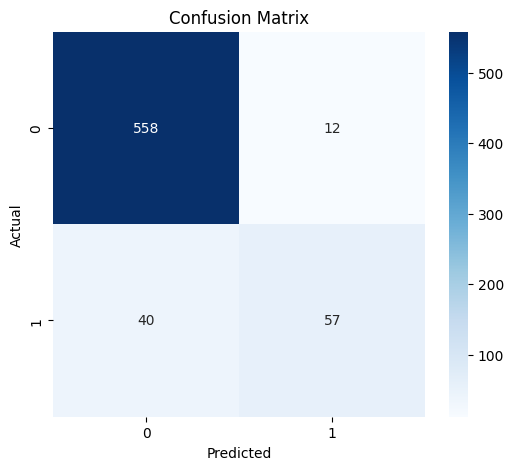

Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.98      0.96       570
         1.0       0.83      0.59      0.69        97

    accuracy                           0.92       667
   macro avg       0.88      0.78      0.82       667
weighted avg       0.92      0.92      0.92       667



In [13]:
# evaluation metrics 

accuracy = accuracy_score(y_true, y_pred_class)
precision = precision_score(y_true, y_pred_class)
recall = recall_score(y_true, y_pred_class)
f1 = f1_score(y_true, y_pred_class)
roc_auc = roc_auc_score(y_true, y_pred_prob)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"ROC-AUC:   {roc_auc:.4f}")

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_class)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_class))

In [14]:
# log metrics to MLflow 

mlflow.set_experiment("Churn_ANN_Experiment_Evaluation")
with mlflow.start_run():
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("roc_auc", roc_auc)
    mlflow.pytorch.log_model(model, "churn_ann_model_evaluation")

2025/12/19 15:20:52 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/12/19 15:20:52 INFO mlflow.store.db.utils: Updating database tables
2025/12/19 15:20:52 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2025/12/19 15:20:52 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2025/12/19 15:20:52 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2025/12/19 15:20:52 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2025/12/19 15:20:52 INFO mlflow.tracking.fluent: Experiment with name 'Churn_ANN_Experiment_Evaluation' does not exist. Creating a new experiment.
2025/12/19 15:20:53 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
